In [1]:
import os
import ee
import datetime
import time
import sklearn

import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from dateutil.relativedelta import relativedelta
from sklearn import preprocessing
from shapely.ops import unary_union
from pandas.tseries.offsets import MonthEnd

ee.Initialize()


In [3]:
'''
Set the init params:
1) Area: Read from Shapefile
2) Years to analyze: Supplied
3) Scale (optional): Resolution at which to perform analysis
4) Satellites / datasets: Queried from Earth Engine
'''

##### AREA #####

# HUC 4s draining to the CV 
cv = gp.read_file("../shape/argus_grace.shp")
cv2 = cv.geometry.simplify(0.1)
lls = cv2.geometry.iloc[0]
x,y = lls.exterior.coords.xy
coords = [list(zip(x,y))]
area = ee.Geometry.Polygon(coords)
sa_km3 = round(cv2.area[0] * 10000, 2)
        
##### TIME RANGE #####
years = [x for x in range(2001, 2018)]
months = range(1,13)

##### SCALE #####


In [4]:
def get_grace(dataset, year, month):

    col = dataset[0]
    var = dataset[1]
    scaling_factor = dataset[2]

    t = col.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(month, month, 'month')).select(var).filterBounds(area).sum()
    t2 = t.multiply(ee.Image.pixelArea()).multiply(scaling_factor).multiply(1e-6) # Multiply by pixel area in km^2
    
    scale = t2.projection().nominalScale()
    sumdict  = t2.reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = area,
            scale = scale)
    
    result = sumdict.getInfo()[var] * 1e-5 # cm to km

    return result

def wrapper(dataset):
    monthly = []

    for year in years:
        print(year)
        for month in months:
            try:
                r = get_grace(dataset, year, month)
                monthly.append(r)
            except:
                monthly.append(np.nan)
    
    print("wrapper complete")
    return monthly

In [5]:
years = range(2003, 2018)
months = range(1,13)
start = datetime.datetime(years[0], 1, 1)
end = datetime.datetime(years[-1]+1, 1, 1)
dt_idx = pd.date_range(start,end, freq='M')

In [6]:
data = {}

data['jpl'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND'), "lwe_thickness_jpl",  ee.Image("NASA/GRACE/MASS_GRIDS/LAND_AUX_2014").select("SCALE_FACTOR")]
data['jpl_unc'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND'), "uncertainty", 1]

data['csr'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND'), "lwe_thickness_csr",  ee.Image("NASA/GRACE/MASS_GRIDS/LAND_AUX_2014").select("SCALE_FACTOR")]
data['csr_unc'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND'), "uncertainty", 1]

data['gfz'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND'), "lwe_thickness_gfz",  ee.Image("NASA/GRACE/MASS_GRIDS/LAND_AUX_2014").select("SCALE_FACTOR")]
data['gfz)_unc'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND'), "uncertainty", 1]

data['mas'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/MASCON'), "lwe_thickness", 1] 
data['mas_unc'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/MASCON'), "uncertainty", 1] 

data['cri'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/MASCON_CRI'), "lwe_thickness", 1] 
data['cri_unc'] = [ee.ImageCollection('NASA/GRACE/MASS_GRIDS/MASCON_CRI'), "uncerrtainty", 1] 


In [7]:
cri = wrapper(data['cri'])
mas = wrapper(data['mas'])
gfz = wrapper(data['gfz'])
csr = wrapper(data['csr'])
jpl = wrapper(data['jpl'])

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
wrapper complete
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
wrapper complete
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
wrapper complete
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
wrapper complete
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
wrapper complete


In [8]:
gfz_unc = wrapper(data['gfc_unc'])
jpl_unc = wrapper(data['jpl_unc'])
csr_unc = wrapper(data['csr_unc'])
mas_unc = wrapper(data['mas_unc'])
cri_unc = wrapper(data['cri_unc'])

KeyError: 'gfc_unc'

/anaconda3/envs/gis/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


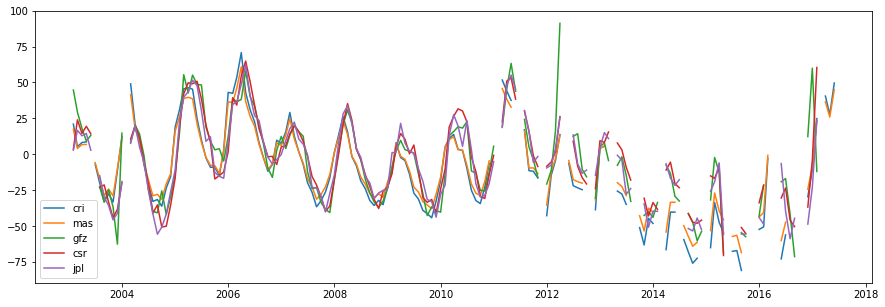

In [9]:
plt.figure(figsize=(15,5))

plt.plot(dt_idx, cri, label = "cri")
plt.plot(dt_idx, mas, label = "mas")
plt.plot(dt_idx, gfz, label = "gfz")
plt.plot(dt_idx, csr, label = 'csr')
plt.plot(dt_idx, jpl, label = 'jpl')
plt.legend()

In [10]:
# Make a dataframe

df = pd.DataFrame([cri,mas,gfz,csr,jpl]).T
df.columns = ["cri", "mas", "gfz", "csr", "jpl"]
df.index = dt_idx


In [11]:
df2 = df.interpolate(method='polynomial', order=3)

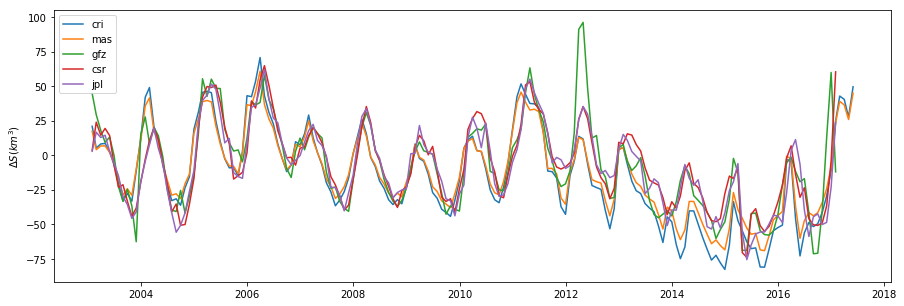

In [12]:
plt.figure(figsize=(15,5))

plt.plot(df2.cri, label = "cri")
plt.plot(df2.mas, label = 'mas')
plt.plot(df2.gfz, label = 'gfz')
plt.plot(df2.csr, label = 'csr')
plt.plot(df2.jpl, label = 'jpl')
plt.ylabel("$\Delta S (km^3)$")

plt.legend()

In [14]:
df2['grace_mean'] = np.nanmean([df2.csr, df2.gfz, df2.jpl , df2.cri, df2.mas], axis = 0)

/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [15]:
df2.to_csv("../data/grace_argus.csv")